# RNN 做图像分类
前面我们讲了 RNN 特别适合做序列类型的数据，那么 RNN 能不能想 CNN 一样用来做图像分类呢？下面我们用 mnist 手写字体的例子来展示一下如何用 RNN 做图像分类，但是这种方法并不是主流，这里我们只是作为举例。

对于一张手写字体的图片，其大小是 28 * 28，我们可以将其看做是一个长为 28 的序列，每个序列的特征都是 28，也就是

![](https://tva1.sinaimg.cn/large/006tKfTcly1fmu7d0byfkj30n60djdg5.jpg)

这样我们解决了输入序列的问题，对于输出序列怎么办呢？其实非常简单，虽然我们的输出是一个序列，但是我们只需要保留其中一个作为输出结果就可以了，这样的话肯定保留最后一个结果是最好的，因为最后一个结果有前面所有序列的信息，就像下面这样

![](https://tva1.sinaimg.cn/large/006tKfTcly1fmu7fpqri0j30c407yjr8.jpg)

下面我们直接通过例子展示

In [1]:
import torch
from torch.autograd import Variable
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms as tfs
from torchvision.datasets import MNIST
import numpy as np

In [2]:
# 定义数据
data_tf = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize([0.5], [0.5]) # 标准化
])

train_data = MNIST('./data', train=True,download = True, transform=data_tf)
test_data = MNIST('./data', train=False,download = True, transform=data_tf)

train_loader = DataLoader(train_data, 64, True, num_workers=4)
test_loader = DataLoader(test_data, 128, False, num_workers=4)

In [3]:
# 定义模型
class rnn_classify(nn.Module):
    def __init__(self, in_feature=28, hidden_feature=100, num_class=10, num_layers=2):
        super(rnn_classify, self).__init__()
        self.rnn = nn.LSTM(in_feature, hidden_feature, num_layers) # 使用两层 lstm
        self.classifier = nn.Linear(hidden_feature, num_class) # 将最后一个 rnn 的输出使用全连接得到最后的分类结果
        
    def forward(self, x):
        '''
        x 大小为 (batch, 1, 28, 28)，所以我们需要将其转换成 RNN 的输入形式，即 (28, batch, 28)
        '''
        x = x.squeeze() # 去掉 (batch, 1, 28, 28) 中的 1，变成 (batch, 28, 28)
        x = x.permute(2, 0, 1) # 将最后一维放到第一维，变成 (28, batch, 28)
        out, _ = self.rnn(x) # 使用默认的隐藏状态，得到的 out 是 (28, batch, hidden_feature)
        out = out[-1, :, :] # 取序列中的最后一个，大小是 (batch, hidden_feature)
        out = self.classifier(out) # 得到分类结果
        return out

In [4]:
# 定义模型
class rnn_classify(nn.Module):
    def __init__(self, in_feature=28, hidden_feature=100, num_class=10, num_layers=2):
        super(rnn_classify, self).__init__()
        self.rnn = nn.LSTM(in_feature, hidden_feature, num_layers, batch_first = True) # 使用两层 lstm 将batch放在前面
        self.classifier = nn.Linear(hidden_feature, num_class) # 将最后一个 rnn 的输出使用全连接得到最后的分类结果
        
    def forward(self, x):
        '''
        x 大小为 (batch, 1, 28, 28)，所以我们需要将其转换成 RNN 的输入形式，即 (28, batch, 28)
        '''
        x = x.squeeze() # 去掉 (batch, 1, 28, 28) 中的 1，变成 (batch, 28, 28)
        out, _ = self.rnn(x) # 使用默认的隐藏状态，得到的 out 是 (batch, 28, hidden_feature)
        out = out[:, -1, :] # 取序列中的最后一个，大小是 (batch, hidden_feature)
        out = self.classifier(out) # 得到分类结果
        return out

In [5]:
train_data.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
classes = train_data.classes

In [7]:
import matplotlib.pyplot as plt
def imshow(img):
    img = img *0.5 + 0.5
    img = img.numpy()
    img = img.squeeze()
    plt.imshow(img)

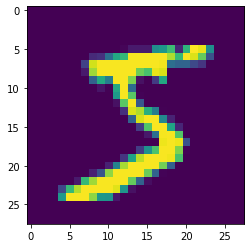

In [8]:
imshow(train_data.data[0])

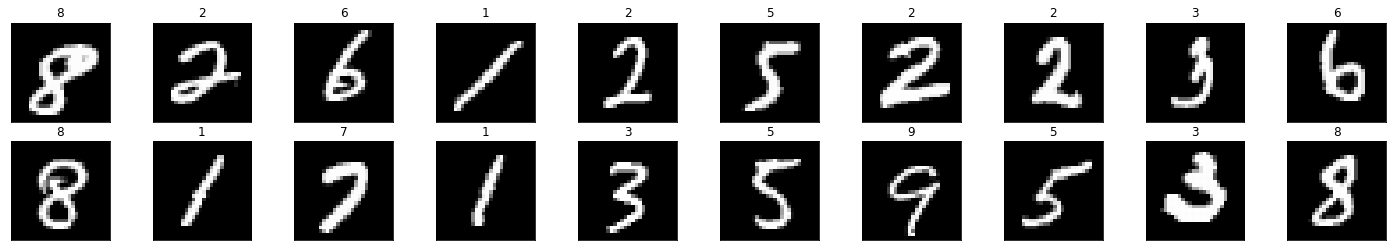

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
images = images * 0.5 + 0.5
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

In [11]:
img = np.squeeze(images[11])
img.shape

(28, 28)

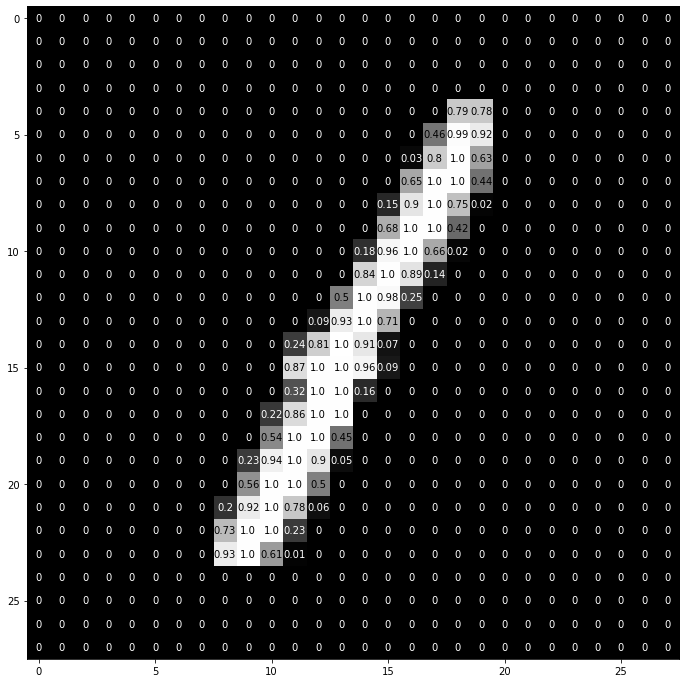

In [12]:
fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y] < thresh else 'black')
        

In [12]:
device = 'cuda' if torch.cuda.is_available else 'cpu'

In [13]:
net = rnn_classify().to(device)
criterion = nn.CrossEntropyLoss()

optimzier = torch.optim.Adadelta(net.parameters(), 1e-1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimzier, patience=3, factor= 0.5,min_lr=1e-6)

In [14]:
test_x = torch.randn(3,1,28,28).to(device)
test_y = net(test_x)
print(test_y.shape)

torch.Size([3, 10])


In [15]:
# 开始训练
from utils import train
Acc,Loss,Lr = train(net, train_loader, test_loader, 10, optimzier, criterion, scheduler, verbose=True)

Epoch [  1/ 10]  Train Loss:1.750572  Train Acc:37.02% Test Loss:0.697916  Test Acc:77.95%  Learning Rate:0.100000	Time 00:14
Epoch [  2/ 10]  Train Loss:0.361676  Train Acc:88.89% Test Loss:0.193300  Test Acc:94.48%  Learning Rate:0.100000	Time 00:13
Epoch [  3/ 10]  Train Loss:0.187760  Train Acc:94.27% Test Loss:0.176153  Test Acc:94.53%  Learning Rate:0.100000	Time 00:14
Epoch [  4/ 10]  Train Loss:0.138180  Train Acc:95.82% Test Loss:0.150296  Test Acc:95.45%  Learning Rate:0.100000	Time 00:13
Epoch [  5/ 10]  Train Loss:0.110974  Train Acc:96.59% Test Loss:0.119391  Test Acc:96.45%  Learning Rate:0.100000	Time 00:14
Epoch [  6/ 10]  Train Loss:0.093230  Train Acc:97.19% Test Loss:0.103071  Test Acc:96.94%  Learning Rate:0.100000	Time 00:15
Epoch [  7/ 10]  Train Loss:0.081078  Train Acc:97.50% Test Loss:0.093530  Test Acc:97.21%  Learning Rate:0.100000	Time 00:15
Epoch [  8/ 10]  Train Loss:0.070568  Train Acc:97.83% Test Loss:0.075076  Test Acc:97.76%  Learning Rate:0.100000	Tim

可以看到，训练 10 次在简单的 mnist 数据集上也取得的了 98% 的准确率，所以说 RNN 也可以做做简单的图像分类，但是这并不是他的主战场，下次课我们会讲到 RNN 的一个使用场景，时间序列预测。

In [16]:
# 定义2个存储每类中测试正确的个数的 列表，初始化为0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

net.eval()
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)

        _, predicted = torch.max(outputs.data, 1)
        # 4组(batch_size)数据中，输出于label相同的，标记为1，否则为0
        c = (predicted == labels).squeeze()
        for i in range(len(images)):      # 因为每个batch都有4张图片，所以还需要一个4的小循环
            label = labels[i]   # 对各个类的进行各自累加
            class_correct[label] += c[i]
            class_total[label] += 1

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %.2f%% (%2d/%2d)' % (
            classes[i] , 100 * class_correct[i] / class_total[i],
            class_correct[i], class_total[i]))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %.2f%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of 0 - zero: 99.08% (971/980)
Test Accuracy of 1 - one: 99.56% (1130/1135)
Test Accuracy of 2 - two: 98.26% (1014/1032)
Test Accuracy of 3 - three: 97.33% (983/1010)
Test Accuracy of 4 - four: 97.86% (961/982)
Test Accuracy of 5 - five: 98.09% (875/892)
Test Accuracy of 6 - six: 97.91% (938/958)
Test Accuracy of 7 - seven: 99.22% (1020/1028)
Test Accuracy of 8 - eight: 97.54% (950/974)
Test Accuracy of 9 - nine: 96.23% (971/1009)

Test Accuracy (Overall): 98.13% (9813/10000)


Accuracy Rate = 100.0%


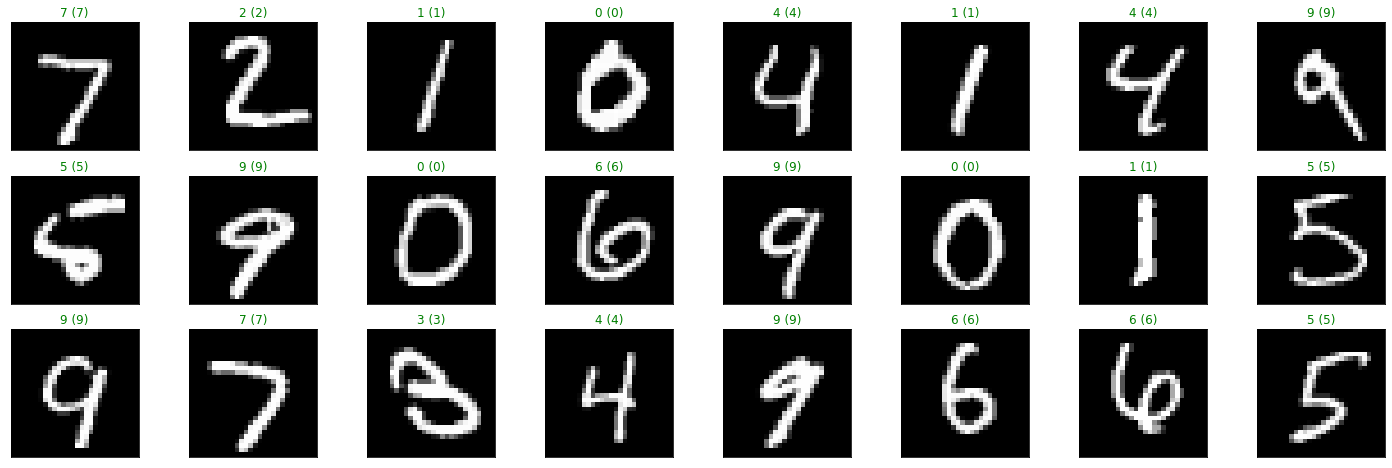

In [17]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images_ = images
#images_ = images_.view(images.shape[0], -1)
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)


correct = torch.sum(val_preds == labels.data).item()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(24):
    ax = fig.add_subplot(3, 8,idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(val_preds[idx].item()), str(labels[idx].item())),
                 color=("green" if val_preds[idx]==labels[idx] else "red"))